In [ ]:
#!pip install tiktoken rouge_score streamlit

In [48]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from collections import Counter
from bs4 import BeautifulSoup
from transformers import pipeline, GPTNeoForCausalLM, GPT2Tokenizer
import tiktoken
import nltk
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
import streamlit as st

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


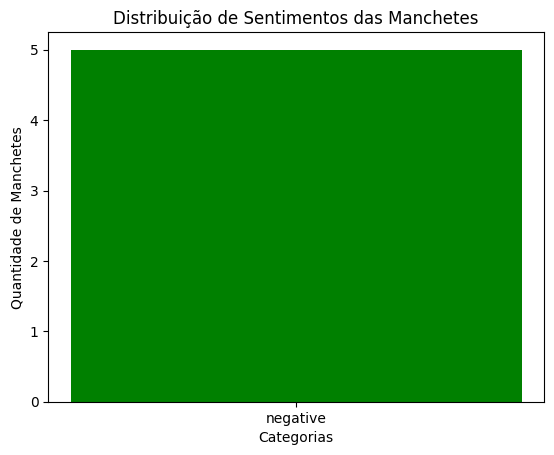

Interpretação dos Resultados:
100.00% das manchetes são negatives.


In [13]:


def obter_links_pagina_difusora(url):
    response_difusora = requests.get(url)
    soup = BeautifulSoup(response_difusora.text, "html.parser")
    links = soup.select("a[alt]")
    return [link["href"] for link in links if link.get("href")]

url_base = "https://difusoranews.com/"
numero_paginas = 5
todos_os_links = set()

for i in range(1, numero_paginas + 1):
    url = f"{url_base}page/{i}"
    links = obter_links_pagina_difusora(url)
    for link in links:
        if len(todos_os_links) < 5:
            todos_os_links.add(link)
        else:
            break
    if len(todos_os_links) >= 5:
        break

classificador_sentimento = pipeline("sentiment-analysis")

def categorizar_manchetes(manchetes):
    resultados = []
    for manchete in manchetes:
        resultado = classificador_sentimento(manchete)
        categoria = resultado[0]["label"].lower()

        resultados.append({"manchete": manchete, "categoria": categoria})

    return resultados

def salvar_resultados(resultados):
    with open("resultados.json", "w", encoding="utf-8") as f:
        json.dump(resultados, f, ensure_ascii=False, indent=4)

def criar_grafico(resultados):
    categorias = [resultado["categoria"] for resultado in resultados]
    contador = Counter(categorias)
    plt.bar(contador.keys(), contador.values(), color=["green", "blue", "red"])
    plt.xlabel("Categorias")
    plt.ylabel("Quantidade de Manchetes")
    plt.title("Distribuição de Sentimentos das Manchetes")
    plt.show()

def main():
    manchetes = list(todos_os_links)
    resultados = categorizar_manchetes(manchetes)
    salvar_resultados(resultados)
    criar_grafico(resultados)

    categorias = [resultado["categoria"] for resultado in resultados]
    contador = Counter(categorias)
    total = sum(contador.values())
    print("Interpretação dos Resultados:")
    for categoria, quantidade in contador.items():
        percentual = (quantidade / total) * 100
        print(f"{percentual:.2f}% das manchetes são {categoria}s.")

if __name__ == "__main__":
    main()


In [17]:
df_personagens = pd.read_csv("/content/simpsons_characters.csv", low_memory=False)
df_episodios = pd.read_csv("/content/simpsons_episodes.csv", low_memory=False)
df_localizacoes = pd.read_csv("/content/simpsons_locations.csv", low_memory=False)
df_linhas_script = pd.read_csv("/content/simpsons_script_lines.csv", low_memory=False)

In [19]:
df_localizacoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               4459 non-null   int64 
 1   name             4459 non-null   object
 2   normalized_name  4459 non-null   object
dtypes: int64(1), object(2)
memory usage: 104.6+ KB


In [20]:
print(df_personagens.columns)
print(df_episodios.columns)
print(df_localizacoes.columns)
print(df_linhas_script.columns)

Index(['id', 'name', 'normalized_name', 'gender'], dtype='object')
Index(['id', 'image_url', 'imdb_rating', 'imdb_votes', 'number_in_season',
       'number_in_series', 'original_air_date', 'original_air_year',
       'production_code', 'season', 'title', 'us_viewers_in_millions',
       'video_url', 'views'],
      dtype='object')
Index(['id', 'name', 'normalized_name'], dtype='object')
Index(['id', 'episode_id', 'number', 'raw_text', 'timestamp_in_ms',
       'speaking_line', 'character_id', 'location_id', 'raw_character_text',
       'raw_location_text', 'spoken_words', 'normalized_text', 'word_count'],
      dtype='object')


In [26]:
df_linhas_script["character_id"] = pd.to_numeric(df_linhas_script["character_id"], errors="coerce").fillna(0).astype(int)
df_personagens["id"] = pd.to_numeric(df_personagens["id"], errors="coerce").fillna(0).astype(int)

df_linhas_script["location_id"] = pd.to_numeric(df_linhas_script["location_id"], errors="coerce").fillna(0).astype(int)
df_localizacoes["id"] = pd.to_numeric(df_localizacoes["id"], errors="coerce").fillna(0).astype(int)

df_linhas_script["episode_id"] = pd.to_numeric(df_linhas_script["episode_id"], errors="coerce").fillna(0).astype(int)
df_episodios["id"] = pd.to_numeric(df_episodios["id"], errors="coerce").fillna(0).astype(int)

df_combinado = df_linhas_script.merge(df_personagens, left_on="character_id", right_on="id", suffixes=("_linha", "_personagem"))
df_combinado = df_combinado.merge(df_localizacoes, left_on="location_id", right_on="id", suffixes=("_combinado", "_localizacao"))
df_combinado = df_combinado.merge(df_episodios, left_on="episode_id", right_on="id", suffixes=("", "_episodio"))

codificador = tiktoken.get_encoding("cl100k_base")

def calcular_tokens(texto):
    if pd.isna(texto):
        return 0
    return len(codificador.encode(texto))

df_combinado["tokens"] = df_combinado["raw_text"].apply(calcular_tokens)

tokens_por_episodio = df_combinado.groupby("episode_id")["tokens"].sum().reset_index()
tokens_por_episodio = tokens_por_episodio.merge(df_episodios, left_on="episode_id", right_on="id")
tokens_por_episodio = tokens_por_episodio[["episode_id", "title", "season", "tokens"]]

tokens_por_temporada = tokens_por_episodio.groupby("season")["tokens"].sum().reset_index()
tokens_por_temporada.rename(columns={"tokens": "total_tokens"}, inplace=True)

print("Tokens por episódio:")
tokens_por_episodio.sort_values(by="tokens", ascending=False)


Tokens por episódio:


,episode_id,title,season,tokens
227,228,Brother's Little Helper,11,6626
230,231,E-I-E-I-(Annoyed Grunt),11,6347
232,233,Eight Misbehavin',11,6339
184,185,The Two Mrs. Nahasapeemapetilons,9,6323
0,1,Simpsons Roasting on an Open Fire,1,6319
...,...,...,...,...
549,554,The Wreck of the Relationship,26,3493
283,284,Blame It on Lisa,13,3257
76,77,So It's Come to This: A Simpsons Clip Show,4,3235
285,286,Gump Roast,13,2594


In [25]:
print("Tokens por temporada:")
tokens_por_temporada.sort_values(by="total_tokens", ascending=False)


Tokens por temporada:


,season,total_tokens
7,8,133348
6,7,132393
8,9,130137
9,10,129346
2,3,127524
5,6,122219
10,11,122034
1,2,119754
4,5,111949
13,14,108791


In [ ]:
tokens_por_episodio.to_csv("tokens_por_episodio.csv", index=False)
tokens_por_temporada.to_csv("tokens_por_temporada.csv", index=False)

In [30]:
sentimento_analisador = pipeline("sentiment-analysis")

id_episodio = 92
temporada_episodio = 5

df_episodio = df_combinado[(df_combinado["episode_id"] == id_episodio) & (df_combinado["season"] == temporada_episodio)]

dialogos = df_episodio[["raw_text"]]

resultados = sentimento_analisador(dialogos["raw_text"].tolist())

df_resultados = pd.DataFrame(resultados, columns=["label", "score"])
df_resultados["raw_text"] = dialogos["raw_text"].values

mapeamento_rotulos = {
    "POSITIVE": "Positivo",
    "NEGATIVE": "Negativo",
    "NEUTRAL": "Neutro"
}

df_resultados["sentimento"] = df_resultados["label"].map(mapeamento_rotulos)

distribuicao = df_resultados["sentimento"].value_counts()

print("Distribuição de fala por categoria:")
distribuicao

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Distribuição de fala por categoria:


,count
sentimento,
Negativo,139
Positivo,109


In [31]:
avaliacao_amostras = df_resultados.sample(n=15, random_state=42)

print("Amostras de avaliação:")
avaliacao_amostras

Amostras de avaliação:


,label,score,raw_text,sentimento
33,NEGATIVE,0.997001,Chief Wiggum: (PANICKED) Let's get outta here!,Negativo
6,POSITIVE,0.994491,Marge Simpson: And my necklace.,Positivo
182,NEGATIVE,0.998739,Grampa Simpson: No. Actually I fell down at th...,Negativo
86,NEGATIVE,0.999738,"Homer Simpson: (CONSIDERS HIM BRIEFLY) Sorry, ...",Negativo
156,POSITIVE,0.999581,Homer Simpson: (À LA MERV) We'll be right back.,Positivo
246,NEGATIVE,0.999585,"Chief Wiggum: No, no! Dig up, stupid!",Negativo
195,POSITIVE,0.762778,Grampa Simpson: Well kiss me right here. It's ...,Positivo
104,NEGATIVE,0.992410,"Herman Hermann: See, it's a miniature version ...",Negativo
9,NEGATIVE,0.988275,"Homer Simpson: (SNORTS) Oh, you've probably go...",Negativo
235,NEGATIVE,0.998082,Driver: (À LA PHIL SILVERS) Whatsa matter with...,Negativo


In [32]:
precisao_por_classe = df_resultados["sentimento"].value_counts(normalize=True)
print("Precisão por classe:")
precisao_por_classe

Precisão por classe:


,proportion
sentimento,
Negativo,0.560484
Positivo,0.439516


In [38]:
encoder = tiktoken.get_encoding("cl100k_base")

def calcular_tokens(texto):
    if pd.isna(texto):
        return 0
    return len(encoder.encode(texto))

resumo = """O episódio começa com Selma Bouvier, a irmã de Patty, em busca de um parceiro para compartilhar sua vida. Em um evento social, ela conhece Jub-Jub, um homem educado e charmoso que a impressiona logo de cara. Selma, que sempre teve dificuldade em encontrar alguém especial, vê nele uma chance de felicidade e começa a se encontrar com ele com frequência.

Enquanto isso, a família Simpson, e em especial Marge, tem opiniões divididas sobre o relacionamento. Marge, preocupada com a irmã e com a influência que isso pode ter na mãe, desconfia de que Selma está se deixando levar por alguém que não é quem parece ser. A desconfiança de Marge cresce quando ela percebe que Jub-Jub tem intenções egoístas e só está interessado em Selma por motivos que não têm nada a ver com amor verdadeiro.

O ponto de tensão chega quando Selma decide se casar com Jub-Jub. O casamento é planejado com grande entusiasmo e a cerimônia promete ser grandiosa, com todos da cidade convidados. Mas, na véspera do grande dia, Marge descobre o passado de Jub-Jub e fica mais convencida de que ele não é digno de confiança.

Ela, com a ajuda de Homer – que, mesmo não sendo o mais confiável dos aliados, acaba sendo uma peça importante para ajudar na situação – decide agir. Juntos, eles fazem de tudo para expor a verdade sobre Jub-Jub e convencer Selma de que ela merece algo melhor.

No grande dia do casamento, a verdade vem à tona. Selma percebe que estava prestes a fazer uma escolha errada e toma a decisão de terminar com Jub-Jub. Ele fica arrasado, mas Selma se sente aliviada e, finalmente, livre de uma situação que não a fazia feliz. A família Simpson se reúne para apoiar Selma, e a celebração que se segue é uma lembrança de que o verdadeiro amor é aquele que é sincero e recíproco."""

num_tokens = calcular_tokens(resumo)
print(f"Quantidade de tokens do resumo: {num_tokens}")

Quantidade de tokens do resumo: 503


In [ ]:
nome_modelo = "EleutherAI/gpt-neo-2.7B"
modelo = GPTNeoForCausalLM.from_pretrained(nome_modelo, pad_token_id=50256)
tokenizador = GPT2Tokenizer.from_pretrained(nome_modelo)

def criar_partes(df, tamanho_parte=100, sobreposicao=25):
    partes = []
    total_linhas = len(df)
    inicio = 0
    while inicio < total_linhas:
        fim = min(inicio + tamanho_parte, total_linhas)
        parte = df.iloc[inicio:fim]
        partes.append(parte)
        inicio = max(0, inicio + tamanho_parte - sobreposicao)
    return partes

def resumir_parte(parte):
    texto = " ".join(parte["raw_text"].tolist())
    comprimento_max_input = 1024

    entradas = tokenizador.encode("Resuma o seguinte texto: " + texto, return_tensors="pt", max_length=comprimento_max_input, truncation=True)

    ids_resumo = modelo.generate(
        entradas,
        max_new_tokens=150,
        num_beams=3,
        early_stopping=True
    )
    resumo = tokenizador.decode(ids_resumo[0], skip_special_tokens=True)
    return resumo

tamanho_parte = 100
sobreposicao = 25
partes = criar_partes(df_episodio, tamanho_parte=tamanho_parte, sobreposicao=sobreposicao)

resumos_partes = []
for i, parte in enumerate(partes):
    resumo_parte = resumir_parte(parte)
    resumos_partes.append(resumo_parte)

prompt_resumo_final = f"""
Você tem uma série de resumos de partes de um episódio. Seu objetivo é combinar esses resumos e criar um resumo final coeso e completo.
Aqui estão os resumos das partes:

{" ".join(resumos_partes[:5])}  # Incluir os primeiros 5 resumos como exemplo
Por favor, crie um resumo final que destaque a história e os principais acontecimentos do episódio.
"""

entradas_resumo_final = tokenizador.encode(prompt_resumo_final, return_tensors="pt", max_length=1024, truncation=True)
ids_resumo_final = modelo.generate(
    entradas_resumo_final,
    max_new_tokens=150,
    num_beams=3,
    early_stopping=True
)
resumo_final = tokenizador.decode(ids_resumo_final[0], skip_special_tokens=True)

quantidade_partes = len(partes)
print(f"Quantidade de partes necessárias: {quantidade_partes}")
print("Resumo final do episódio:")
print(resumo_final)


In [ ]:
nltk.download("punkt")

def calcular_bleu(referencia, hipoteses):
    referencia = [nltk.word_tokenize(referencia.lower())]
    hipoteses = nltk.word_tokenize(hipoteses.lower())
    pontuacao = sentence_bleu(referencia, hipoteses)
    return pontuacao

def calcular_rouge(referencia, hipoteses):
    avaliador = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    pontuacoes = avaliador.score(referencia, hipoteses)
    return pontuacoes

resumo_final_modelo = resumo_final
resumos_chunks_modelo = resumos_partes

resumo_final_referencia = resumo
resumos_chunks_referencia = resumos_partes

bleu_final = calcular_bleu(resumo_final_referencia, resumo_final_modelo)
rouge_final = calcular_rouge(resumo_final_referencia, resumo_final_modelo)

bleu_chunks = [calcular_bleu(resumos_chunks_referencia[i], resumo_chunk) for i, resumo_chunk in enumerate(resumos_chunks_modelo)]
rouge_chunks = [calcular_rouge(resumos_chunks_referencia[i], resumo_chunk) for i, resumo_chunk in enumerate(resumos_chunks_modelo)]

print("Métricas para o resumo final:")
print(f"BLEU: {bleu_final}")
print(f"ROUGE-1: {rouge_final['rouge1']}, ROUGE-2: {rouge_final['rouge2']}, ROUGE-L: {rouge_final['rougeL']}")

print("Métricas para os resumos dos chunks:")
for i, (bleu, rouge) in enumerate(zip(bleu_chunks, rouge_chunks)):
    print(f"Chunk {i+1}:")
    print(f"BLEU: {bleu}")
    print(f"ROUGE-1: {rouge['rouge1']}, ROUGE-2: {rouge['rouge2']}, ROUGE-L: {rouge['rougeL']}")

In [43]:
avaliacao_amostras.to_csv("arquivo_avaliacao_sentimento.csv")

In [44]:
avaliacao_amostras.columns

Index(['label', 'score', 'raw_text', 'sentimento'], dtype='object')

In [ ]:
"""Crie um código em Python usando Streamlit para ler um arquivo CSV chamado "arquivo_avaliacao_sentimento.csv".
Esse arquivo contém as colunas ['label', 'score', 'raw_text', 'sentimento'].
Certifique-se de exibir os dados na interface do Streamlit para que possamos conferir que a leitura foi realizada corretamente.

Agora, com base nos dados que você leu do CSV, crie um gráfico de pizza em Streamlit para mostrar a proporção de falas de cada categoria de sentimento ("Positivo", "Negativo", "Neutro").
Use a biblioteca de visualização matplotlib.pyplot

Junte tudo e escreva uma aplicação Streamlit completa que faça a leitura do arquivo CSV chamado "arquivo_avaliacao_sentimento.csv",
exiba os dados e mostre um gráfico de pizza com a distribuição de falas por categoria de sentimento e me envie o código gerado em python para que seja possível testar no google colab, utilizando o comando %%writefile modelo.py
""";

In [65]:
%%writefile modelo.py
import matplotlib.pyplot as plt
def carregar_dados(caminho):
    dados = pd.read_csv("arquivo_avaliacao_sentimento.csv")
    return dados

dados = carregar_dados("arquivo_avaliacao_sentimento.csv")
st.write("Dados de análise de sentimento:")
st.dataframe(dados)

contagem_sentimentos = dados['sentimento'].value_counts()
figura, eixos = plt.subplots()
eixos.pie(contagem_sentimentos, labels=contagem_sentimentos.index, autopct='%1.1f%%', startangle=140)
eixos.set_title("Distribuição de Fala por Categoria de Sentimento")
st.pyplot(figura)

st.write("A aplicação está pronta para exibir os dados e o gráfico de pizza.")


Overwriting modelo.py


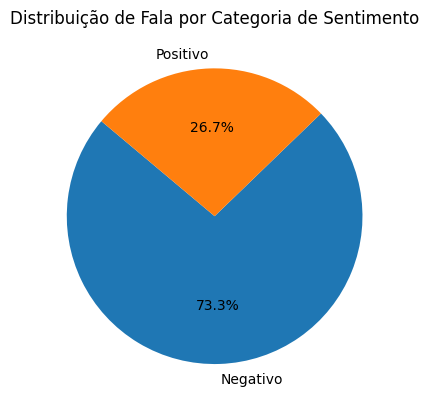

In [63]:
figura

In [66]:
!streamlit run modelo.py





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.229.209.145:8501

  Stopping...


In [69]:
"""A LLM foi sim capaz de implementar parcialmente a aplicação
pois ocorreram alguns problemas relacionados a mainthread.
O objetivo de cada etapa era:
Extrair os dados
Instruir o que deve ser visualizado
Instruir como deve ser a execução """;